<a id ='TOC'></a>
### Table of Contents
4. [Models](#Models) <br/>
    4.1 [Baseline Model - Simple Linear Regression](#Baseline-Model) <br/>
    4.2 [Linear Regression with Ridge](#Linear-Regression-with-Ridge) <br/>
    4.3 [Lasso](#Lasso) <br/>
    4.4 [Lasso and Ridge Coefficients Comparison](#Lasso-and-Ridge-Coefficients-Comparison) <br/>
    4.5 [Logistic Regression](#Logistic-Regression) <br/>
    4.6 [Logistic Regression with cross validation](#Logistic-Regression-with-cross-validation) <br/>
    4.7 [Logistic Regression with polynomial degree 3](#Logistic-Regression-with-polynomial-degree-3) <br/>
    4.8 [KNN](#KNN) <br/>
    4.9 [Decision tree](#Decision-tree) <br/>
    4.10 [Random Forest](#Random-Forest) <br/>
    4.11 [Boosting - AdaBoost Classifier](#Boosting-AdaBoost-Classifier) <br/>
    4.12 [SVM](#SVM) <br/>
    4.13 [K-Means Clustering](#KMeans-Clustering) <br/>
    4.14 [Validate Botometer Results](#Validate-Botometer-Results) <br/>
    4.15 [Sentence Embeddings + Clutering + Neural Networks](#Sentence-Embeddings-Clutering-Neural-Networks)<br/>

___

In [0]:
#@title 
# Import Libraries, Global Options and Styles
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)
%matplotlib inline

#import libraries
import warnings
warnings.filterwarnings('ignore')

import tweepy
import random
random.seed(112358)

%matplotlib inline
import numpy as np
import scipy as sp
import json as json
import pandas as pd
import jsonpickle
import time


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from pandas.plotting import scatter_matrix
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

import scipy.sparse as ss
import os
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from keras.utils import np_utils

import statsmodels.api as sm
from statsmodels.api import OLS

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn.apionly as sns
sns.set(style="darkgrid")
sns.set_context("poster")

Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


[Back to TOC](#TOC) <br/>
<a id ='Models'></a>
### 4 - Models

We splited train / test dataset by 0.25 and stratify by class_boto to ensure equal presentation of bots account in both datasets. The baseline accuracy of training dataset was 91.73%, the baseline accuracy for test set was 91.77%. Both of which are quite high. <br/>
<mark> By testing several model, we were able to achieve an accuracy up to  </mark> 

In [0]:
# read the data
users_df = pd.read_json('users_final_std.json')

In [0]:
# Train/Test split 
'''
change as needed, do we want test_size of .25?
'''
train_df, test_df = train_test_split(users_df, test_size=.25, 
                                                       stratify=users_df.class_boto, random_state=99)

In [0]:
with open('col_pred_numerical.txt', 'r') as fp:
    col_pred_numerical = fp.read().split(',')
with open('col_response.txt', 'r') as fp:
    col_response = fp.read().split(',')
with open('col_pred_text.txt', 'r') as fp:
    col_pred_text = fp.read().split(',')
with open('col_ref.txt', 'r') as fp:
    col_ref = fp.read().split(',')

In [0]:
# write a function to split the data
def split_data(df):
    # num_pred: standardized numerical predictors - what we will be using for most of the models
    # text_pred: text features that are associated with the tweets - only useful for NLP
    # response: response - manually verified classification. 1=bot; 0=non-bot
    # ids: 'id'
    # boto: botometer values
    num_pred, text_pred, response = df[col_pred_numerical], df[col_pred_text], df['class_boto']
    ids, screen_name = df['id'], df['screen_name']
    return num_pred, text_pred, response, ids, screen_name

In [0]:
# get the predictors, responses, and other features from train and test set
xtrain, xtrain_text, ytrain, train_id, train_sn = split_data(train_df)
xtest, xtest_text, ytest, test_id, test_sn = split_data(test_df)

In [0]:
# save to json
f_list_names = ['train_df', 'test_df', 'xtrain', 'xtrain_text', 'ytrain', 'train_id', 'train_sn', 'xtest', 'xtest_text', 'ytest', 'test_id', 'test_sn']
f_list = [train_df, test_df, xtrain, xtrain_text, ytrain, train_id, train_sn, xtest, xtest_text, ytest, test_id, test_sn]
for f_name, f in zip(f_list_names, f_list):
    f.to_json(f_name + '.json')

In [0]:
# create a dictionary to store all our models
models_list = {}
acc ={}

In [0]:
# take a quick look at the accuracy if we just choose to classifying everything as users
baseline_train_acc = float(1-sum(ytrain)/len(ytrain))
baseline_test_acc = float(1-sum(ytest)/len(ytest))
print('the baseline accuracy for training set is {:.2f}%, for test set is {:.2f}%.'.format(baseline_train_acc*100, 
                                                                                           baseline_test_acc*100))

the baseline accuracy for training set is 91.73%, for test set is 91.77%.


In [0]:
# save baseline acc to model list
acc['bl'] = (baseline_train_acc, baseline_test_acc)

[Back to TOC](#TOC) <br/>
<a id ='Baseline-Model'></a>
#### 4.1 - Baseline Model - Simple Linear Regression

Although this is a classification problem that people normally won't use linear regression, we thought we could try with a threshold of 0.5 and use it as a baseline model.  <br/>

Our Test score is around 91.39% on the test data which is not bad for a Base Model at the first glance; as our possibilies are either Bot or No-Bot. However, it is actually lower than our baseline accuracy on test set, which was 91.77%. Therefore, OLS, even we tried to use threshold, it is not performing, we need to improve the model.

In [0]:
# multiple linear regression(no poly)on numerical predictors
X_train = sm.add_constant(xtrain)
X_test = sm.add_constant(xtest)
y_train = ytrain.values.reshape(-1,1)
y_test = ytest.values.reshape(-1,1)

In [0]:
# Fit and summarize OLS model
model = OLS(y_train, X_train)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     45.83
Date:                Wed, 12 Dec 2018   Prob (F-statistic):          3.40e-151
Time:                        21:45:50   Log-Likelihood:                -23.162
No. Observations:                3169   AIC:                             86.32
Df Residuals:                    3149   BIC:                             207.5
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0845      0.004     19.328      0.000       0.076       0.093
user_favourites_count    -0.0111      0.004     -2.478      0.013      -0.020      -0.002
user_followers_count     -0.0473      0.011     -4.433      0.000      -0.068      -0.026
user_friends_count        0.0281      0.005      5.138      0.000       0.017       0.039
user_listed_count         0.0332      0.009      3.816      0.000       0.016       0.050
user_statuses_count      -0.0052      0.004     -1.218      0.223      -0.014       0.003
tweet_time_mean           0.1159      0.039      2.964      0.003       0.039       0.193
tweet_time_std           -0.0043      0.029     -0.148      0.883      -0.061       0.052
tweet_time_min           -0.0337      0.008     -4.427      0.000      -0.049      -0.019
tweet_time_max           -0.0053      0.015     -0.360      0.719      -0.034       0.023
user_description_len     -0.0011      0.005     -0.234      0.815      -0.010       0.008
account_age              -0.0367      0.004     -8.171      0.000      -0.046      -0.028
tweet_len_mean            0.0171      0.007      2.621      0.009       0.004       0.030
tweet_len_std            -0.0579      0.006     -9.066      0.000      -0.070      -0.045
tweet_word_mean          -0.0577      0.008     -7.453      0.000      -0.073      -0.043
tweet_word_std            0.0065      0.007      0.871      0.384      -0.008       0.021
retweet_len_mean          0.0167      0.008      2.003      0.045       0.000       0.033
retweet_len_std           0.0007      0.007      0.107      0.915      -0.013       0.014
retweet_word_mean        -0.1547      0.016     -9.530      0.000      -0.187      -0.123
retweet_word_std          0.0783      0.015      5.145      0.000       0.048       0.108
==============================================================================
Omnibus:                     1418.815   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6760.888
Skew:                           2.163   Prob(JB):                         0.00
Kurtosis:                       8.699   Cond. No.                         21.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
y_hat_train = results.predict()
y_hat_test = results.predict(exog=X_test)

# get Train & Test R^2
print('Train R^2 = {}'.format(results.rsquared))
print('Test R^2 = {}'.format(r2_score(test_df['class_boto'], y_hat_test)))

Train R^2 = 0.21662050202218985
Test R^2 = -0.2992911496733639


In [0]:
# accuracy score
ols_train_acc = accuracy_score(y_train, results.predict(X_train).round().clip(0, 1))
ols_test_acc = accuracy_score(y_test, results.predict(X_test).round().clip(0, 1))
print("Training accuracy is {:.4}%".format(ols_train_acc*100))
print("Test accuracy is {:.4} %".format(ols_test_acc*100))

Training accuracy is 91.86%
Test accuracy is 91.39 %


In [0]:
# save model to the list
models_list["ols"] = results
acc['ols'] = (ols_train_acc, ols_test_acc)

In [0]:
# pickle ols
import pickle

filename = 'ols.sav'
pickle.dump(results, open(filename, 'wb'))

In [0]:
#loaded_model = pickle.load(open(filename,'rb'))

[Back to TOC](#TOC) <br/>
<a id ='Linear-Regression-with-Ridge'></a>
#### 4.2 - Linear Regression with Ridge

Although in the simple linear model, the test score is comparable to training score and there was no sign of overfitting, we still want to try Ridge to see if we could reduce any potential overfitting. <br/>

With ridge selection, we received a test accuracy of 91.96%, which is slightly improved from 91.39% (OLS), which implies that the OLS model does not have overfitting. However, it is still about the same / lower than baseline accuracy.

In [0]:
alphas = np.array([.01, .05, .1, .5, 1, 5, 10, 50, 100])
fitted_ridge = RidgeCV(alphas=alphas, cv=5).fit(X_train, y_train)

In [0]:
# accuracy score
ridge_train_acc = accuracy_score(y_train, fitted_ridge.predict(X_train).round().clip(0, 1))
ridge_test_acc = accuracy_score(y_test, fitted_ridge.predict(X_test).round().clip(0, 1))
print("Training accuracy is {:.4}%".format(ridge_train_acc*100))
print("Test accuracy is {:.4} %".format(ridge_test_acc*100))

Training accuracy is 91.92%
Test accuracy is 91.96 %


In [0]:
# save model to the list
models_list["ridge"] = fitted_ridge
filename = 'ridge.sav'
pickle.dump(fitted_ridge, open(filename, 'wb'))
acc['ridge'] = (ridge_train_acc, ridge_test_acc)

[Back to TOC](#TOC) <br/>
<a id ='Lasso'></a>
#### 4.3 - Lasso
We also want to try feature reductions with Lasso and see if the model will perform better by dropping less important features. The lasso model received an accuracy of 91.77%, which again improves from 91.14% but not very significant, and it is just slightly higher than baseline accuracy. However, Lasso may not have significant improvement on test accuracy but lead to differnet coefficients. We want to examine that.

In [0]:
fitted_lasso = LassoCV(alphas=alphas, max_iter=100000, cv=5).fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
# accuracy score
lasso_train_acc = accuracy_score(y_train, fitted_lasso.predict(X_train).round().clip(0, 1))
lasso_test_acc = accuracy_score(y_test, fitted_lasso.predict(X_test).round().clip(0, 1))
print("Training accuracy is {:.4}%".format(lasso_train_acc*100))
print("Test accuracy is {:.4} %".format(lasso_test_acc*100))

Training accuracy is 91.8%
Test accuracy is 91.77 %


In [0]:
# save model to the list
models_list["lasso"] = fitted_lasso
filename = 'lasso.sav'
pickle.dump(fitted_lasso, open(filename, 'wb'))
acc['lasso']=(lasso_train_acc, lasso_test_acc)

[Back to TOC](#TOC) <br/>
<a id ='Lasso-and-Ridge-Coefficients-Comparison'></a>
#### 4.4 -  Lasso and Ridge Coefficients Comparison
We want to see how lasso and ridge results in different coefficients. As expected, Lasso greatly reduced the number of non-zero coefficients.

In [0]:
for feature, coef in zip(xtrain.columns.values.tolist(), fitted_ridge.coef_[0].tolist()):
    print("{}: {}".format(feature, coef))

user_favourites_count: 0.0
user_followers_count: -0.010984392775297717
user_friends_count: -0.0373860331993809
user_listed_count: 0.024158234955190823
user_statuses_count: 0.026646084813644076
tweet_time_mean: -0.0044977208562929465
tweet_time_std: 0.044232900606536285
tweet_time_min: 0.029995359711894685
tweet_time_max: -0.02480300277881136
user_description_len: -0.012475212935169604
account_age: -0.0015423611100371431
tweet_len_mean: -0.03616251833633441
tweet_len_std: 0.01451572510127823
tweet_word_mean: -0.054079504222467004
tweet_word_std: -0.0514121927327697
retweet_len_mean: 0.0025870175288910087
retweet_len_std: 0.007751629182111389
retweet_word_mean: -0.003022968737127
retweet_word_std: -0.09823618767855992


In [0]:
for feature, coef in zip(xtrain.columns.values.tolist(), fitted_lasso.coef_.tolist()):
    print("{}: {}".format(feature, coef))

user_favourites_count: 0.0
user_followers_count: -0.0030684119532310974
user_friends_count: -0.0
user_listed_count: 0.005861006334253806
user_statuses_count: 0.0
tweet_time_mean: -0.0
tweet_time_std: 0.0
tweet_time_min: 0.019705055827586075
tweet_time_max: -0.0
user_description_len: 0.0
account_age: -0.0
tweet_len_mean: -0.02878718176736991
tweet_len_std: 0.0
tweet_word_mean: -0.04152323503512772
tweet_word_std: -0.03718634181572111
retweet_len_mean: -0.0
retweet_len_std: -0.0
retweet_word_mean: -0.0
retweet_word_std: -0.06062048667775922


[Back to TOC](#TOC) <br/>
<a id ='Logistic-Regression'></a>
#### 4.5 - Logistic Regression

The logistic regression presented a small improvement on the accuracy from the base model, we need to try additional techniques to improve the accuracy.

In [0]:
X_train = sm.add_constant(xtrain)
X_test = sm.add_constant(xtest)

logistic_model = LogisticRegression().fit(X_train, ytrain)

logistic_model_score = logistic_model.score(X_test, ytest)

print("Train set score: {0:4.4}%".format(logistic_model.score(X_train, ytrain)*100))
print("Test set score: {0:4.4}%".format(logistic_model.score(X_test, ytest)*100))

Train set score: 92.55%
Test set score: 91.49%


In [0]:
models_list["simple_logistic"] = logistic_model
filename = 'simple_logistic.sav'
pickle.dump(logistic_model, open(filename, 'wb'))
acc['lm'] = (logistic_model.score(X_train, ytrain), logistic_model_score)

[Back to TOC](#TOC) <br/>
<a id ='Logistic-Regression-with-cross-validation'></a>
#### 4.6 - Logistic Regression with cross validation

Logistic regression with Cross Validation has improved the accuracy and reached 91.96% on Test data which is an improvement from the Logistic regression, we will continue to see if we can improve further using other techniques.

In [0]:
logistic_model_cv = LogisticRegressionCV(Cs=[1,10,100,1000,10000], cv=3, penalty='l2', 
                                       solver='newton-cg').fit(X_train,ytrain)

print("Train set score with Cross Validation: {0:4.4}%".format(logistic_model_cv.score(X_train, ytrain)*100))
print("Test set score with Cross Validation: {0:4.4}%".format(logistic_model_cv.score(X_test, ytest)*100))

Train set score with Cross Validation: 92.58%
Test set score with Cross Validation: 91.96%


In [0]:
models_list["simple_logistic_Cross_Validation"] = logistic_model_cv
filename = 'logistic_model_cv.sav'
pickle.dump(logistic_model_cv, open(filename, 'wb'))
acc['lm_cv3'] = (logistic_model_cv.score(X_train, ytrain), logistic_model_cv.score(X_test, ytest))

[Back to TOC](#TOC) <br/>
<a id ='Logistic-Regression-with-polynomial-degree-3'></a>
#### 4.7 - Logistic Regression with polynomial degree 3

Test score accuracy has increased with Polynomial degree of predictors for Logistic Regression on the test data and reached 93.47%. 

In [0]:
X_train_poly = PolynomialFeatures(degree=3, include_bias=False).fit_transform(X_train)

logistic_model_poly_cv = LogisticRegressionCV(Cs=[1,10,100,1000,10000], cv=3, penalty='l2', 
                                       solver='newton-cg').fit(X_train_poly,ytrain)

X_test_poly = PolynomialFeatures(degree=3, include_bias=False).fit_transform(X_test)
print("Train set score with Polynomial Features (degree=3) and with Cross Validation: {0:4.4}%".
      format(logistic_model_poly_cv.score(X_train_poly, ytrain)*100))
print("Test set score with Polynomial Features (degree=3) and with Cross Validation: {0:4.4}%".
      format(logistic_model_poly_cv.score(X_test_poly, ytest)*100))

Train set score with Polynomial Features (degree=3) and with Cross Validation: 98.26%
Test set score with Polynomial Features (degree=3) and with Cross Validation: 93.47%


In [0]:
models_list["poly_logistic_cv"] = logistic_model_poly_cv
filename = 'logistic_model_poly_cv.sav'
pickle.dump(logistic_model_poly_cv, open(filename, 'wb'))
acc['lm_poly3'] = (logistic_model_poly_cv.score(X_train_poly, ytrain), logistic_model_poly_cv.score(X_test_poly, ytest))

[Back to TOC](#TOC) <br/>
<a id ='KNN'></a>
#### 4.8 - KNN

We have tested the k-Nearest Neighbors algorithm as well and we used cross validation to evaluate the best k with the highest accuracy score. We have stored the best k in the variable best_k which has a value equal of 17. The test score is higher than the base model but lower than Logistic Regression with polynomial degree 3.

In [0]:
# the code below in KNN is adapted from HW2 solution

# define k values
k_values = range(1,20)

# build a dictionary KNN models
KNNModels = {k: KNeighborsClassifier(n_neighbors=k) for k in k_values}
train_scores = [KNeighborsClassifier(n_neighbors=k).fit(xtrain, ytrain).score(xtrain, ytrain) for k in k_values]
cv_scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k), xtrain, ytrain, cv=5) for k in k_values]


# fit each KNN model
for k_value in KNNModels: 
    KNNModels[k_value].fit(xtrain, ytrain)

In [0]:
# Generate predictions
knn_predicted_train = {k: KNNModels[k].predict(xtrain) for k in KNNModels}
knn_predicted_test = {k: KNNModels[k].predict(xtest) for k in KNNModels}

In [0]:
# the following code was adapted from HW7 solutions
def plot_cv(ax, hyperparameter, cv_scores):
    cv_means = np.mean(cv_scores, axis=1)
    cv_stds = np.std(cv_scores, axis=1)
    handle, = ax.plot(hyperparameter, cv_means, '-*', label="Validation (mean)")
    plt.fill_between(hyperparameter, cv_means - 2.*cv_stds, cv_means + 2.*cv_stds, alpha=.3, color=handle.get_color())

Best k: 17


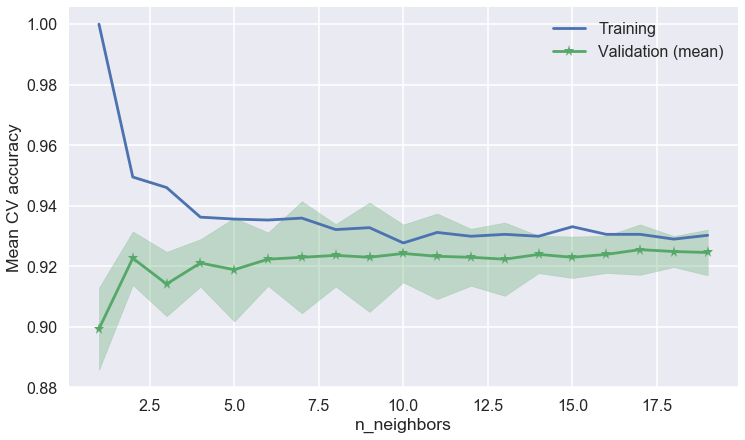

In [0]:
# the following code was adapted from HW7 solutions
# find the best model
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(k_values, train_scores, '-+', label="Training")
plot_cv(ax, k_values, cv_scores)
plt.xlabel("n_neighbors")
plt.ylabel("Mean CV accuracy");
plt.legend()

best_k = k_values[np.argmax(np.mean(cv_scores, axis=1))]
print("Best k:", best_k)

In [0]:
# evaluate classification accuracy
best_model_KNN_train_score = accuracy_score(ytrain, knn_predicted_train[best_k].round())
best_model_KNN_test_score = accuracy_score(ytest, knn_predicted_test[best_k].round())
print("Training accuracy is {:.4}%".format(best_model_KNN_train_score*100))
print("Test accuracy is {:.4} %".format(best_model_KNN_test_score*100))

Training accuracy is 93.06%
Test accuracy is 92.72 %


In [0]:
# save model to the list
best_k = 17
best_k_17 = KNNModels[best_k].fit(xtrain, ytrain)

models_list["knn_17"] = best_k_17
filename = 'knn_17.sav'
pickle.dump(best_k_17, open(filename, 'wb'))
acc['knn_17'] = (best_model_KNN_train_score, best_model_KNN_test_score)

[Back to TOC](#TOC) <br/>
<a id ='Decision-tree'></a>
#### 4.9 - Decision tree

The decision tree is performing similiar to the logistic regression with polynomial 3. 

In [0]:
depth_list =list(range(1, 18))

cv_means = []
cv_stds = []
train_scores = []
best_model_mean = 0

for depth in depth_list:
    #Fit a decision tree to the training set
    model_DTC = DecisionTreeClassifier(max_depth=depth).fit(xtrain, ytrain)
    scores = cross_val_score(model_DTC, xtrain, ytrain, cv=5)
    
    #training set performance
    train_scores.append(model_DTC.score(xtrain, ytrain))
    
    #save best model
    if scores.mean() > best_model_mean:
            best_model_mean=scores.mean()
            best_model_DTC=model_DTC
            best_model_std =scores.std()
            
    
    #performance for 5-fold cross validation
    cv_means.append(scores.mean())
    cv_stds.append(scores.std())
    

cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)
train_scores = np.array(train_scores)

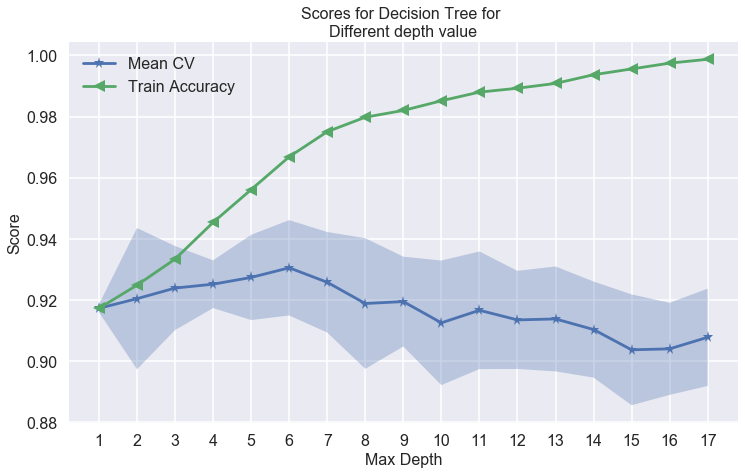

In [0]:
plt.subplots(1, 1, figsize=(12,7))
plt.plot(depth_list, cv_means, '*-', label="Mean CV")
plt.fill_between(depth_list, cv_means - 2*cv_stds, cv_means + 2*cv_stds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depth_list, train_scores, '<-', label="Train Accuracy")
plt.legend()
plt.ylabel("Score", fontsize=16)
plt.xlabel("Max Depth", fontsize=16)
plt.title("Scores for Decision Tree for \nDifferent depth value", fontsize=16)
plt.xticks(depth_list);

In [0]:
best_model_DTC_train_score = accuracy_score(ytrain, best_model_DTC.predict(xtrain))
best_model_DTC_test_score = accuracy_score(ytest, best_model_DTC.predict(xtest))
print("Training accuracy is {:.4}%".format(best_model_DTC_train_score*100))
print("Test accuracy is {:.4}%".format(best_model_DTC_test_score*100))

Training accuracy is 96.69%
Test accuracy is 92.53%


In [0]:
models_list["decision_tree"] = best_model_DTC
filename = 'decision_tree.sav'
pickle.dump(best_model_DTC, open(filename, 'wb'))
acc['dtc'] = (best_model_DTC_train_score, best_model_DTC_test_score )

[Back to TOC](#TOC) <br/>
<a id ='Random-Forest'></a>
#### 4.10 -Random Forest

The Random Forest is giving us the highest accuracy from all the models tested so far on the test data. but we may be able to increase this value with Boosting or Bagging.

In [0]:
rf = RandomForestClassifier(max_depth=6)
rf_model = rf.fit(xtrain, ytrain)
rf_train_acc = rf_model.score(xtrain, ytrain)
rf_test_acc = rf_model.score(xtest, ytest)

print("Random Forest Training accuracy is {:.4}%".format(rf_train_acc*100))
print("Random Forest Test accuracy is {:.4}%".format(rf_test_acc*100))

Random Forest Training accuracy is 95.71%
Random Forest Test accuracy is 93.85%


In [0]:
models_list["random_forest"] = rf_model
filename = 'random_forest.sav'
pickle.dump(rf_model, open(filename, 'wb'))
acc['rf'] = (rf_train_acc, rf_test_acc)

[Back to TOC](#TOC) <br/>
<a id ='Boosting-AdaBoost-Classifier'></a>
#### 4.11 -Boosting - AdaBoost Classifier

For the model with depth = 1, the accuracy for train and test datasets are close to each other. However, for the models with depth = 2, 3 and 4, there are a big difference in the accuracy for test and train data. I would choose depth =2 and iterations = 180. This model is performing the best so far.

In [0]:
AdaBoost_models = {}
AdaBoost_scores_train = {}
AdaBoost_scores_test = {}
for e in range(1, 5):
    AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=e), n_estimators=800, learning_rate=0.05)
    AdaBoost_models[e] = AdaBoost.fit(xtrain, ytrain)
    AdaBoost_scores_train[e] = list(AdaBoost_models[e].staged_score(xtrain, ytrain))
    AdaBoost_scores_test[e] = list(AdaBoost_models[e].staged_score(xtest, ytest))

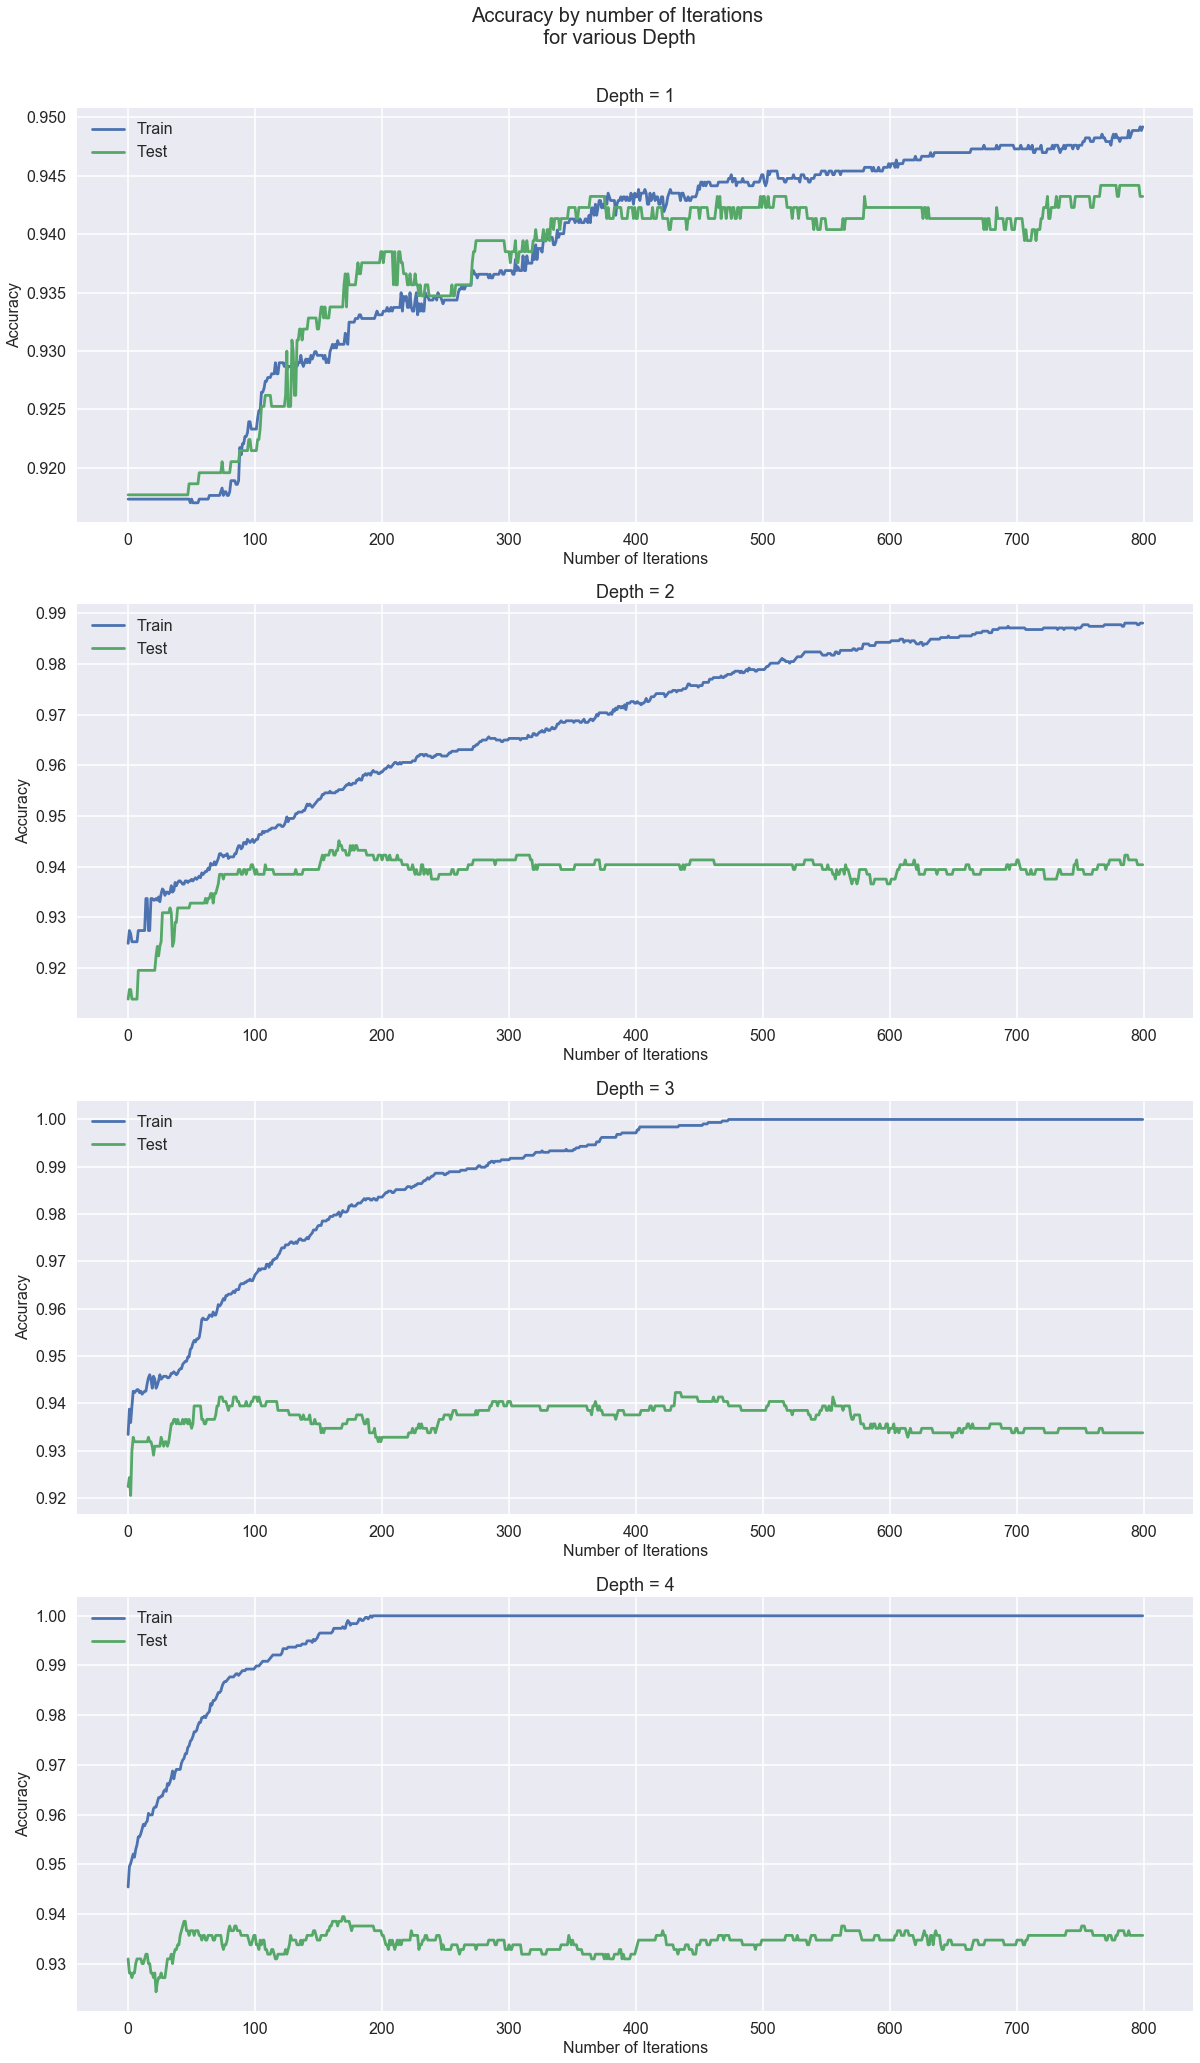

In [0]:
fig, ax = plt.subplots(4,1, figsize=(20,35))
for e in range(0, 4):
    ax[e].plot(AdaBoost_scores_train[e+1], label='Train')
    ax[e].plot(AdaBoost_scores_test[e+1], label='Test')
    ax[e].set_xlabel('Number of Iterations', fontsize=16)
    ax[e].set_ylabel('Accuracy', fontsize=16)
    ax[e].tick_params(labelsize=16)
    ax[e].legend( fontsize=16)
    ax[e].set_title('Depth = %s'%(e+1), fontsize=18)
fig.suptitle('Accuracy by number of Iterations\n for various Depth',y=0.92,fontsize=20);

In [0]:
AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=800, learning_rate=0.05)
AdaBoost_2 = AdaBoost.fit(xtrain, ytrain)

In [0]:
models_list["AdaBoost_2"] = AdaBoost_2
filename = 'AdaBoost_2.sav'
pickle.dump(AdaBoost_2, open(filename, 'wb'))
acc['adaboost'] = (AdaBoost_scores_train[2][179], AdaBoost_scores_test[2][179])

[Back to TOC](#TOC) <br/>
<a id ='SVM'></a>
#### 4.12 -SVM

We tried SVM and reached a test accuracy of 93.28%. As it is an expensive model, we ended up using eyeballing to fit a model so we can try the SVM method. However, ideally, we would like to perform a grid search to find te best kernal and c value.

In [0]:
# Import the Libraries Needed
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Load the Data

# Fit a SVM Model by Grid Search
# parameters = {'kernel':('linear','rbf','poly','sigmoid'), 'C':[0.01,0.1,1,10,100]}
# svc = svm.SVC(random_state=0)
# svm_model = GridSearchCV(svc, parameters, cv=5)
# svm_model.fit(X_train, ytrain)

# Fit a Model by Eyeballing
svm_model = svm.SVC(kernel='poly',C=1,degree=4, random_state=0)  
svm_model.fit(xtrain, ytrain) 

#models_list = []
models_list["SVM"] =  svm_model
print("Train set score: {0:4.4}%".format(svm_model.score(xtrain, ytrain)*100))
print("Test set score: {0:4.4}%".format(svm_model.score(xtest, ytest)*100))

Train set score: 94.98%
Test set score: 93.28%


In [0]:
filename = 'svm.sav'
pickle.dump(svm_model, open(filename, 'wb'))
acc['svm_poly_c1'] = (svm_model.score(xtrain, ytrain), svm_model.score(xtest, ytest))

In [0]:
# we have finished all our models. we want to save the accuracy score and models to json
with open('models.pickle', 'wb') as handle:
    pickle.dump(models_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
acc = pd.DataFrame(acc)
acc.to_json('acc.json')

[Back to TOC](#TOC) <br/>
<a id ='KMeans-Clustering'></a>
#### 4.13 - K-Means Clustering

We want to explore if unsupervised k-means clustering align with bot / non-bot classification.

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, init='random', random_state=0).fit(users_df[col_pred_numerical].values)

In [0]:
# add the classification result
k2 = users_df[col_pred_numerical]

k2['k=2'] = kmeans.labels_

In [0]:
# create df for easy plot
kmean_0 = k2.loc[k2['k=2']==0]
kmean_1 = k2.loc[k2['k=2']==1]
class_0 = users_df.loc[users_df['class_boto']==0]
class_1 = users_df.loc[users_df['class_boto']==1]

In [0]:
# see how many were classified as bots
print ('The size of the two clusters from kmeans clustering are {} and {}.'.format(len(kmean_0), len(kmean_1)))

The size of the two clusters from kmeans clustering are 277 and 3949.


Given the size of cluster 0, it looks like cluster 0 might be a bot cluster.<br/>

We picked two arbitary features to visualize the two clusters from unsupervised KMeans (k=2), and how they align with botometer classification. Visually they align well, and we want to see how many bots are in cluster 0 and non-bots in cluster 1.

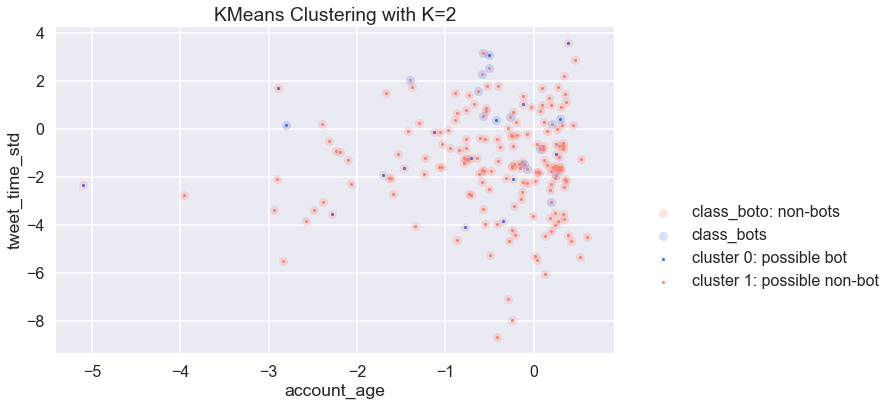

In [0]:
# quick plot to see if it naturally come into two clusters
plt.figure(figsize=(10,6))
plt.scatter(np.log(class_0['account_age']), np.log(class_0['tweet_time_std']), c='salmon', s=70, label = 'class_boto: non-bots', alpha=0.2)
plt.scatter(np.log(class_1['account_age']), np.log(class_1['tweet_time_std']), c='royalblue', s=70, label = 'class_bots', alpha=0.2)
plt.scatter(np.log(kmean_0['account_age']), np.log(kmean_0['tweet_time_std']), c='royalblue', s=7, label = 'cluster 0: possible bot', alpha=1)
plt.scatter(np.log(kmean_1['account_age']), np.log(kmean_1['tweet_time_std']), c='salmon', s=7, label = 'cluster 1: possible non-bot', alpha=1)
plt.xlabel('account_age')
plt.ylabel('tweet_time_std')
plt.title('KMeans Clustering with K=2')
plt.legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 0.5));

In [0]:
# proportion of cluster 0 users which are bots (precision)
precision_bot_0 = k2[(users_df['class_boto']==1) & (k2['k=2']==0)].shape[0] / kmean_0.shape[0]
print ('proportion of cluster 0 users which are bots (precision) is {:.2f}%'.format(precision_bot_0*100))

proportion of cluster 0 users which are bots (precision) is 36.46%


In [0]:
# proportion of bots which are in cluster 0 (recall)
recall_bot_0 = k2[(users_df['class_boto']==1) & (k2['k=2']==0)].shape[0] / class_1.shape[0]
print ('proportion of bots which are in cluster 0 (recall) is {:.2f}%'.format(recall_bot_0*100))

proportion of bots which are in cluster 0 (recall) is 28.94%


In [0]:
# proportion of cluster 1 users which are bots (precision)
precision_bot_1 = k2[(users_df['class_boto']==1) & (k2['k=2']==1)].shape[0] / kmean_1.shape[0]
print ('proportion of cluster 1 users which are bots (precision) is {:.2f}%'.format(precision_bot_1*100))

proportion of cluster 1 users which are bots (precision) is 6.28%


In [0]:
# proportion of bots which are in cluster 1 (recall)
recall_bot_1 = k2[(users_df['class_boto']==1) & (k2['k=2']==1)].shape[0] / class_1.shape[0]
print ('proportion of bots which are in cluster 0 (recall) is {:.2f}%'.format(recall_bot_1*100))

proportion of bots which are in cluster 0 (recall) is 71.06%


However, when we look at precision and recall for cluster 0 being bots and cluster 1 being bots, we observed that clusters are not as well aligned with botometer classification as the graph is showing above. <br/>

It looks like cluster 0 would a better choice as bot cluster as it has a better precision. Therefore KMeans looks like a promising approach in identifying bots and non-bots with unsupervised learning. KMeans clustering could also be used in supervised learning model as a predictor.

In [0]:
filename = 'kmeans.sav'
pickle.dump(kmeans, open(filename, 'wb'))

[Back to TOC](#TOC) <br/>
<a id ='Validate-Botometer-Results'></a>
#### 4.14 - Validate Botometer Results
  
When comparing botometer scores and manually classified results, we noticed that botometer does not always predict actual bot / non-bot correctly. Therefore we want to compare our verified users with Botometer classifications, and see if we can capture the subspace between botometer results and the manually verified results. <br/>

We try to use a random forest to explore the subspace between botometer results and the actual result (manually verified classification). We chose to use non-linear model as we expect the relationship between botometer result and actual result to be non-linear.  <br/>
  
We want to train a model with one feature plus botometer score as predictors, and the actual classification as the response. In the principle that the botometer is occasionally accurate, and we want to see under what occasions they are accurate / inaccurate, and therefore to capture the residuals between our predictions (which use botometer score as predictors) and the actual results. (* we chose to features as we want to minimize number of features, given our sample size - manually verified bot account - is only 44)

While the model above improved accuracy from 72.73% to 83.33%, the model is very arbitary especially given that our sample size (44) is very small. However, this is an approach that could potentially be further devloped to improve prediction accuracy, especially to train a model with larger training with imperfect labels, and improve it with a smaller training set with better labels.

In [0]:
# load verified bots and nonbots
verify_df = pd.read_csv('boto_verify.csv')[['screen_name', 'class_verified']]
verify_df = verify_df[~verify_df['class_verified'].isnull()]

In [0]:
# build a dataframe that has screen_name, class_bot, class_verified, feature 1
# we picked one arbitary features we think will be important
# and see if we can improve botometer's prediction on verified account accuracy using decision tree 
feature_1 = 'tweet_time_mean'
verify_df = pd.merge(verify_df, users_df[['class_boto', 'screen_name', feature_1]])

In [0]:
# take a look at data
verify_df.drop(columns=['screen_name']).head(5)

,class_verified,class_boto,tweet_time_mean
0,1.0,1,-0.074599
1,1.0,1,-0.075464
2,1.0,0,-0.074661
3,1.0,0,-0.075440
4,1.0,0,-0.075345


In [0]:
# first we want to examine the accuracy of class_boto when cross checking with manually verified classifications
boto_vf_acc = sum(verify_df['class_boto']==verify_df['class_verified'])/len(verify_df['class_boto'])
print ('The accuracy of Botometer in predicting manually verified classification is {:.2f}%.'.format(boto_vf_acc*100))

The accuracy of Botometer in predicting manually verified classification is 71.43%.


In [0]:
# use features and botometer score to predict the validated score

x_train_vf, x_test_vf, y_train_vf, y_test_vf = train_test_split(verify_df[['class_boto', feature_1]], 
                                                                verify_df['class_verified'], test_size=0.4, random_state=50)

dtc_vf = DecisionTreeClassifier(max_depth=2).fit(x_train_vf, y_train_vf)
score = dtc_vf.score(x_test_vf, y_test_vf)

print("The accuracy of decision tree model (depth=3) in predicting manually verified classification is {:.2f}%.".format(score*100))

The accuracy of decision tree model (depth=3) in predicting manually verified classification is 42.86%.


[Back to TOC](#TOC) <br/>
<a id ='Sentence-Embeddings-Clutering-Neural-Networks'></a>
#### 4.15 - Classification of tweets using Sentence Embeddings + Clutering + LDA + Neural Networks

Additionally, we want to explore some models on classifying tweets. 

The team wanted to explore for this project how we can read the text tweets to predict whether the tweets are coming from bot or human. First, we found out that the text tweets require data cleansing (by navigating through the tweets). So we took a sample data and performed manual data cleansing by replacing stopwords, special characters, emoji expressions, numbers and we saved the new clean data under cleaned_tweets.txt file. Then we decided to find how the data can be clustered and grouped together, so we have converted textual tweets data into numerical vectors using tensor flow encoder for the conversion and we have used text clustering using K-means (Mini Batch Kmeans). Then we labeled data into two categories (Group A and Group B as Bot and Human), at this stage we didn't manually labeled the data to check which tweets are coming from Bots or human (as this will require checking the records manually), so we just assigned the data to be labeled into two categories randomly as there are only two options a bot or non-bot. Then we build the Classification model using Neural Network on all sample data(Used Keras lib on top of tensor flow) The next step is to test the model on new datasets and checking the tweets content, this model was done to explore new techniques and discuss how we can do NLP on tweets data.

word embedding details https://www.tensorflow.org/tutorials/representation/word2vec https://www.tensorflow.org/guide/embedding https://www.fer.unizg.hr/_download/repository/TAR-07-WENN.pdf

Clustering https://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html https://algorithmicthoughts.wordpress.com/2013/07/26/machine-learning-mini-batch-k-means/ https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html

Classification http://www.zhanjunlang.com/resources/tutorial/Deep%20Learning%20with%20Keras.pdf https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/ https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

# Sentence Embeddings for Clustering

In [0]:
# converting textual data into numerical vectors for clustering; we have used tensor flow encoder for the conversion
def build_index(embedding_fun, batch_size, sentences):
    ann = []
    batch_sentences = []
    batch_indexes = []
    last_indexed = 0
    num_batches = 0
    with tf.Session() as sess: #starting tensor session 
        sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
        with open('cleaned_tweets.txt', 'r') as fr:
            for sindex, sentence in enumerate(fr):
                batch_sentences.append(sentence)
                batch_indexes.append(sindex)

                if len(batch_sentences) == batch_size:
                    context_embed = sess.run(embedding_fun, feed_dict={sentences: batch_sentences})
                    for index in batch_indexes:
                        ann.append(context_embed[index - last_indexed])
                        batch_sentences = []
                        batch_indexes = []
                    last_indexed += batch_size
                    num_batches += 1
            if batch_sentences:
                context_embed = sess.run(embedding_fun, feed_dict={sentences: batch_sentences})
                for index in batch_indexes:
                    ann.append(context_embed[index - last_indexed])
    return ann

In [0]:
batch_size = 128
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")
sentences = tf.placeholder(dtype=tf.string, shape=[None])
embedding_fun = embed(sentences)
ann = build_index(embedding_fun, batch_size, sentences)

INFO:tensorflow:Using /var/folders/cd/js4b46vx0rq_2zt5bnm1fblw0000gn/T/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# Text Clustering using Kmeans

In [0]:
#We used Kmeans for clustering the data because data is not labeled 
from sklearn.cluster import MiniBatchKMeans
no_clus = 2

In [0]:
km = MiniBatchKMeans(n_clusters=no_clus, random_state=0, batch_size=1000)
km = km.fit(ann)

In [0]:
label_ = km.predict(ann)

# Labels Choosen after Cluster Analysis

In [0]:
#we can give other labels to tweets after analysing the data but right now our motive is to identify bot & non-bots tweets.
label = ["human","bot"]

# Data Preperation for Training Neural Network

In [0]:
#preparing the model fior neural netwwork
ds = pd.DataFrame()
for j in range(0,no_clus):
    temp = pd.DataFrame()
    temp = pd.DataFrame(np.array(ann)[np.where(label_ == j)[0]])
    temp['label'] = (label[j])
    ds = pd.concat((ds,temp), ignore_index = True)
ds.head() 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,label
0,0.014465,-0.041160,-0.080382,0.049232,-0.072470,0.035281,-0.007432,-0.023164,-0.016499,0.059375,0.011128,-0.072195,0.001333,0.081120,-0.043538,0.025982,-0.008040,0.008672,0.046465,-0.041111,0.019693,-0.054316,-0.037432,-0.049775,0.043199,-0.082781,0.022100,-0.055881,0.000243,-0.039490,0.046346,0.045277,0.063884,-0.049139,0.046108,0.046417,0.068380,0.010075,-0.024406,0.054736,0.036027,-0.079516,-0.016540,-0.013671,0.029925,0.019939,0.012983,0.008551,-0.080187,-0.033431,...,0.042374,0.012550,-0.021070,-0.028898,0.041150,-0.040165,-0.015725,-0.064446,-0.043480,-0.038069,0.054859,0.071981,0.059431,-0.059622,0.057350,-0.028784,-0.012592,0.047343,-0.042691,-0.018448,-0.047661,0.018976,-0.020382,-0.007089,0.055725,-0.066460,0.044143,-0.032896,-0.035257,0.045124,-0.077788,0.009261,0.051502,-0.002606,-0.037444,0.028699,0.008687,0.048924,-0.060097,0.011616,-0.043432,-0.057813,0.023498,0.029007,-0.057199,0.033862,0.034509,-0.051691,-0.068487,human
1,-0.004159,0.037407,0.010676,0.051571,-0.082445,0.042067,0.085635,-0.068073,0.008043,-0.057601,-0.010396,0.061897,0.026388,-0.039207,-0.081150,0.062177,-0.025542,-0.005056,-0.055322,0.058100,0.018608,-0.029878,-0.078493,0.080863,-0.065654,0.068974,0.002821,-0.040240,0.057693,-0.048370,0.068685,-0.000077,-0.000213,0.063530,-0.031372,0.023782,-0.004415,-0.041821,0.007741,0.023710,0.070109,0.032692,0.002921,0.077430,-0.029552,0.048876,0.016704,0.049636,-0.067951,-0.050462,...,0.040322,0.027861,-0.008080,0.063199,0.044135,-0.052681,0.019565,0.064226,-0.048641,0.044495,-0.069249,0.004205,0.056537,-0.052674,0.081130,0.020684,0.035940,-0.068895,-0.037510,-0.047443,-0.072809,-0.046582,0.025906,0.014971,0.067606,-0.063587,-0.019536,-0.028843,0.056103,0.070734,-0.072800,0.061065,0.006131,0.008708,-0.019813,-0.031101,0.063472,0.022468,-0.003953,0.034237,-0.014825,0.083977,-0.041056,0.074752,-0.062685,0.030684,-0.066145,-0.046920,-0.046959,human
2,0.018760,0.017700,-0.001465,0.026475,-0.065444,0.055917,0.083909,-0.037637,-0.067772,0.003231,0.060457,0.075828,-0.035041,0.030025,-0.081898,0.017239,-0.062100,0.069808,0.033860,-0.009992,0.061071,-0.034434,-0.062524,0.046930,-0.012984,-0.020368,-0.077449,-0.030762,0.012479,0.034478,0.067442,-0.028413,-0.029516,0.003395,-0.059197,0.062458,0.073726,-0.021924,-0.060282,-0.040060,0.015813,0.018026,0.025038,0.071120,-0.024542,0.010045,-0.029734,0.045184,-0.013265,-0.070352,...,-0.028412,-0.017237,0.011519,0.030776,0.001742,-0.027445,0.077707,0.045478,-0.061658,-0.033477,0.001959,0.028779,0.007566,-0.056936,0.026699,-0.032550,-0.059910,-0.080014,0.006620,0.053456,-0.069313,-0.069715,0.013956,-0.007759,0.058094,-0.011070,0.051757,0.006790,0.052903,0.005722,-0.009652,0.057129,0.016612,-0.002932,-0.079768,0.062508,0.038955,0.049365,-0.052527,-0.017487,-0.031634,0.030714,-0.059589,0.066754,-0.033562,0.026823,0.054268,-0.023460,-0.019951,human
3,0.061679,0.001478,0.031168,0.022693,-0.015502,0.021912,-0.052999,0.000949,-0.068597,0.030209,0.008987,-0.029433,0.011550,-0.020340,-0.031608,0.073531,-0.025333,-0.004687,-0.054933,-0.007605,-0.055760,-0.024632,-0.059326,0.062436,0.032248,0.062266,-0.002961,-0.088176,0.031939,-0.036887,0.005734,-0.023288,0.081136,-0.004106,-0.033513,-0.009084,0.030620,0.043523,0.053875,-0.028582,0.023576,0.021544,0.060563,0.007828,0.023314,-0.045387,-0.053455,0.035316,0.054424,0.004902,...,0.014024,0.060987,0.059613,0.057116,-0.012657,0.040048,0.064219,0.037523,0.028764,-0.028689,0.088758,-0.001394,0.075421,-0.087056,0.040511,0.039444,-0.060023,-0.029292,-0.051675,0.021379,-0.079976,0.030407,-0.033485,0.000740,-0.028985,-0.073933,-0.022529,0.036499,0.049380,0.071529,0.007678,0.055372,0.020072,0.001890,0.04

In [0]:
label_c = len(ds.label.unique())

In [0]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(ds.label)
encoded_Y = encoder.transform(ds.label)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
X = ds.drop('label',axis=1)

encoder.classes_

array(['bot', 'human'], dtype=object)

In [0]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
save_object(encoder,"encoder.pkl")

## NN-Architecture for Multi-Class classification  and Training 

In [0]:
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=512))
model.add(Dense(25, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(label_c, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X,dummy_y, epochs=15, batch_size=64,validation_split=0.15,verbose=2,shuffle=True)

Train on 5241 samples, validate on 926 samples
Epoch 1/15
 - 4s - loss: 0.3245 - acc: 0.9454 - val_loss: 0.0410 - val_acc: 0.9838
Epoch 2/15
 - 0s - loss: 0.0356 - acc: 0.9901 - val_loss: 0.0433 - val_acc: 0.9773
Epoch 3/15
 - 0s - loss: 0.0237 - acc: 0.9920 - val_loss: 0.0218 - val_acc: 0.9924
Epoch 4/15
 - 0s - loss: 0.0200 - acc: 0.9927 - val_loss: 0.0251 - val_acc: 0.9903
Epoch 5/15
 - 0s - loss: 0.0141 - acc: 0.9960 - val_loss: 0.0128 - val_acc: 0.9946
Epoch 6/15
 - 0s - loss: 0.0119 - acc: 0.9966 - val_loss: 0.0274 - val_acc: 0.9881
Epoch 7/15
 - 0s - loss: 0.0107 - acc: 0.9968 - val_loss: 0.0146 - val_acc: 0.9946
Epoch 8/15
 - 0s - loss: 0.0078 - acc: 0.9983 - val_loss: 0.0190 - val_acc: 0.9935
Epoch 9/15
 - 0s - loss: 0.0069 - acc: 0.9983 - val_loss: 0.0251 - val_acc: 0.9914
Epoch 10/15
 - 0s - loss: 0.0046 - acc: 0.9992 - val_loss: 0.0246 - val_acc: 0.9935
Epoch 11/15
 - 0s - loss: 0.0047 - acc: 0.9990 - val_loss: 0.0325 - val_acc: 0.9892
Epoch 12/15
 - 0s - loss: 0.0040 - acc

### Saving Model

In [0]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'